In [1]:
# 1. Uninstall the incompatible "nightly" versions first
!pip uninstall -y torch torchvision torchaudio flash-attn

# 2. Install Stable PyTorch (2.5.1) compatible with CUDA 12.4
print("Installing Stable PyTorch 2.5.1...")
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124

# 3. Install other dependencies
!pip install -q --timeout=1000 accelerate bitsandbytes seaborn safetensors scikit-learn matplotlib

# 4. Install Pre-built Flash Attention
print("Installing Flash Attention Wheel...")
!pip install https://github.com/Dao-AILab/flash-attention/releases/download/v2.7.0.post2/flash_attn-2.7.0.post2+cu124torch2.5cxx11abiFALSE-cp310-cp310-linux_x86_64.whl

Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
Installing Stable PyTorch 2.5.1...
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 112.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
# Install Flash Attention for Python 3.12 + CUDA 12.4 + PyTorch 2.5
# Install build dependencies first
!pip install packaging ninja

# Set MAX_JOBS to use all A100 CPU cores
import os
os.environ["MAX_JOBS"] = "8"

# Compile from source
!pip install flash-attn --no-build-isolation


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 73.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=255984554 sha256=51f6422861ed951b968428adc9fa7406027f73f2145be5e163810df6f459abea
  Stored in directory: /root/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash-attn


In [3]:
import os
import time
import copy
import json
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import (
    ViTForImageClassification,
    ViTConfig,
    BitsAndBytesConfig,
    AutoConfig
)
from safetensors.torch import load_file
from sklearn.metrics import f1_score, accuracy_score
from torch.profiler import profile, record_function, ProfilerActivity

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Updated paths pointing to Google Drive
PATHS = {
    "dataset_root": "/content/drive/MyDrive/Models/flower_data/dataset",

    "baseline_dir": "/content/drive/MyDrive/Models/baseline_model",
    "quant_4bit_dir": "/content/drive/MyDrive/Models/quant_4bit",
    "quant_8bit_dir": "/content/drive/MyDrive/Models/quant_8bit",
}

# Verify the paths exist
print("Verifying folder structure:")
for key, path in PATHS.items():
    if os.path.exists(path):
        print(f"✓ {key}: {path} - EXISTS")
    else:
        print(f"✗ {key}: {path} - NOT FOUND")

Mounted at /content/drive
Verifying folder structure:
✓ dataset_root: /content/drive/MyDrive/Models/flower_data/dataset - EXISTS
✓ baseline_dir: /content/drive/MyDrive/Models/baseline_model - EXISTS
✓ quant_4bit_dir: /content/drive/MyDrive/Models/quant_4bit - EXISTS
✓ quant_8bit_dir: /content/drive/MyDrive/Models/quant_8bit - EXISTS


In [4]:
# 1. FIX THE MISSING DEVICE VARIABLE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device set to: {device}")

# 2. DIAGNOSE THE CORRUPTED BASELINE FILE
baseline_file = os.path.join(PATHS["baseline_dir"], "model.safetensors")

if os.path.exists(baseline_file):
    size_mb = os.path.getsize(baseline_file) / (1024 * 1024)
    print(f"Baseline file size: {size_mb:.2f} MB")

    # A standard ViT-base model should be roughly 330MB - 350MB.
    # If this prints < 100MB or 0MB, the file is corrupted.
    if size_mb < 300:
        print("⚠️ CRITICAL WARNING: Your baseline 'model.safetensors' looks too small or corrupted.")
        print("   Action: Please re-upload 'model.safetensors' to Google Drive folder:")
        print(f"   {PATHS['baseline_dir']}")
    else:
        print("✅ File size looks correct.")
else:
    print("❌ Baseline file not found.")

✅ Device set to: cuda
Baseline file size: 1157.45 MB
✅ File size looks correct.


In [5]:
def get_dataloader(root_dir, batch_size=32):
    valid_dir = os.path.join(root_dir, 'valid')

    # Standard ViT preprocessing
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Load dataset
    # We assume standard ImageFolder structure (numbered folders 1-102)
    dataset = datasets.ImageFolder(valid_dir, transform=transform)

    # Num classes for model config
    num_classes = len(dataset.classes)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return loader, num_classes

# Initialize Data Loader
try:
    val_loader, NUM_CLASSES = get_dataloader(PATHS["dataset_root"])
    print(f"Data Loaded: {len(val_loader.dataset)} images, {NUM_CLASSES} classes.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure you have unzipped the flower dataset into the correct folder.")

Data Loaded: 818 images, 102 classes.


In [9]:
def load_baseline_model(model_dir, num_labels):
    print(f"Loading Baseline from {model_dir}...")

    # FIX: Use ViT-Large config because your weights are 1024-dim
    try:
        config = ViTConfig.from_pretrained("google/vit-large-patch16-224")
    except:
        # Fallback if internet fails, manually set large params
        config = ViTConfig(
            hidden_size=1024,
            num_hidden_layers=24,
            num_attention_heads=16,
            intermediate_size=4096,
            image_size=224,
            patch_size=16
        )

    config.num_labels = num_labels

    # Initialize model with Large config
    model = ViTForImageClassification(config)

    # Load Local Weights
    safetensors_path = os.path.join(model_dir, "model.safetensors")
    if os.path.exists(safetensors_path):
        state_dict = load_file(safetensors_path)

        # Squeeze header if necessary (sometimes needed for custom finetunes)
        if "vit.embeddings.cls_token" not in state_dict and "embeddings.cls_token" in state_dict:
            # Handle case where prefix 'vit.' might be missing in some saves
            new_state_dict = {}
            for k, v in state_dict.items():
                if not k.startswith("vit.") and not k.startswith("classifier."):
                    new_state_dict["vit." + k] = v
                else:
                    new_state_dict[k] = v
            state_dict = new_state_dict

        model.load_state_dict(state_dict, strict=False)
    else:
        raise FileNotFoundError(f"No model.safetensors found in {model_dir}")

    return model

# Keep the quantized loader same as before
def load_quantized_model(model_dir, precision, use_flash_attn=False):
    print(f"Loading {precision}-bit model from {model_dir} (FlashAttn={use_flash_attn})...")

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=(precision == 4),
        load_in_8bit=(precision == 8),
        bnb_4bit_compute_dtype=torch.float16 if precision == 4 else None,
        bnb_4bit_quant_type="nf4" if precision == 4 else "fp4",
    )

    attn_impl = "flash_attention_2" if use_flash_attn else "sdpa"

    model = ViTForImageClassification.from_pretrained(
        model_dir,
        quantization_config=bnb_config,
        attn_implementation=attn_impl,
        device_map="auto",
        torch_dtype=torch.float16
    )
    return model

In [10]:
def benchmark_model(model, dataloader, model_name, device, run_cpu_test=False):
    results = {"Model": model_name}

    # Ensure model is in eval mode
    model.eval()

    # -------------------------------------------------
    # 1. Model Size & Peak Memory
    # -------------------------------------------------
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    size_all_mb = (param_size + buffer_size) / 1024**2
    results["Model Size (MB)"] = round(size_all_mb, 2)

    # Reset peak memory stats
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    # -------------------------------------------------
    # 2. Inference Latency & Throughput (CUDA)
    # -------------------------------------------------
    # Prepare a dummy input for timing
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    if "Quantized" in model_name:
        dummy_input = dummy_input.to(torch.float16)

    # Warmup
    for _ in range(10):
        with torch.no_grad():
            _ = model(dummy_input)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    # Timing loop
    timings = []
    iterations = 50
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    with torch.no_grad():
        for _ in range(iterations):
            start_event.record()
            _ = model(dummy_input)
            end_event.record()
            torch.cuda.synchronize()
            timings.append(start_event.elapsed_time(end_event)) # Returns ms

    timings = torch.tensor(timings)
    results["Latency Mean (ms)"] = round(timings.mean().item(), 2)
    results["Latency P50 (ms)"] = round(timings.quantile(0.5).item(), 2)
    results["Latency P95 (ms)"] = round(timings.quantile(0.95).item(), 2)
    results["Latency P99 (ms)"] = round(timings.quantile(0.99).item(), 2)
    results["Throughput (img/s)"] = round(1000 / results["Latency Mean (ms)"], 2)

    # Record Peak VRAM used during inference
    if torch.cuda.is_available():
        results["Peak VRAM (MB)"] = round(torch.cuda.max_memory_allocated() / 1024**2, 2)
    else:
        results["Peak VRAM (MB)"] = 0

    # -------------------------------------------------
    # 3. CPU Latency (Baseline Only)
    # -------------------------------------------------
    if run_cpu_test:
        # Move a copy to CPU for testing
        try:
            cpu_model = copy.deepcopy(model).cpu()
            cpu_input = torch.randn(1, 3, 224, 224)
            for _ in range(3): # Warmup
                with torch.no_grad(): _ = cpu_model(cpu_input)

            t0 = time.time()
            with torch.no_grad():
                for _ in range(10):
                    _ = cpu_model(cpu_input)
            cpu_avg_ms = ((time.time() - t0) / 10) * 1000
            results["CPU Latency (ms)"] = round(cpu_avg_ms, 2)
            del cpu_model
        except Exception as e:
            print(f"CPU Benchmarking failed: {e}")
            results["CPU Latency (ms)"] = "N/A"
    else:
        results["CPU Latency (ms)"] = "N/A"

    # -------------------------------------------------
    # 4. Accuracy (Top-1, Top-5, F1)
    # -------------------------------------------------
    all_preds = []
    all_labels = []
    correct_top5 = 0
    total_samples = 0

    print(f"Running Accuracy Check for {model_name}...")
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            if "Quantized" in model_name:
                images = images.to(torch.float16)

            outputs = model(images).logits

            # Top-1
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Top-5
            # We use topk to get the top 5 indices
            _, top5_indices = outputs.topk(5, dim=1)

            # Expand labels to match shape for comparison: [batch_size, 1]
            labels_expanded = labels.view(-1, 1)

            # Check if label is in top 5 predictions
            correct_top5 += torch.eq(top5_indices, labels_expanded).sum().item()
            total_samples += labels.size(0)

    results["Top-1 Acc"] = round(accuracy_score(all_labels, all_preds), 4)
    results["Top-5 Acc"] = round(correct_top5 / total_samples, 4)
    results["F1 Score"] = round(f1_score(all_labels, all_preds, average='weighted'), 4)

    # -------------------------------------------------
    # 5. Kernel Profiling
    # -------------------------------------------------
    try:
        with profile(activities=[ProfilerActivity.CUDA], record_shapes=True) as prof:
            with torch.no_grad():
                model(dummy_input)

        cuda_time_total = 0
        flash_time = 0
        attn_time = 0

        # Robustly get attributes
        for evt in prof.key_averages():
            t = getattr(evt, 'cuda_time_total', 0)
            if t == 0: t = getattr(evt, 'cuda_time', 0)

            cuda_time_total += t

            name = evt.key.lower()
            if "flash" in name:
                flash_time += t
            if "attn" in name or "attention" in name:
                attn_time += t

        results["Total CUDA Kernel Time (us)"] = cuda_time_total
        results["Attention Kernel Time (us)"] = flash_time if "Flash" in model_name else attn_time
    except Exception as e:
        print(f"Profiling warning: {e}")
        results["Total CUDA Kernel Time (us)"] = 0
        results["Attention Kernel Time (us)"] = 0

    return results

In [11]:
all_metrics = []

# ------------------------------------------------------
# 1. Baseline ViT
# ------------------------------------------------------
try:
    model_1 = load_baseline_model(PATHS["baseline_dir"], NUM_CLASSES)
    model_1.to(device)
    res_1 = benchmark_model(model_1, val_loader, "1. Baseline ViT", device, run_cpu_test=True)
    all_metrics.append(res_1)
    del model_1
    torch.cuda.empty_cache()
except Exception as e:
    print(f"Failed to benchmark Model 1: {e}")

# ------------------------------------------------------
# 2. 4-bit + SDPA
# ------------------------------------------------------
try:
    model_2 = load_quantized_model(PATHS["quant_4bit_dir"], precision=4, use_flash_attn=False)
    res_2 = benchmark_model(model_2, val_loader, "2. 4-bit + SDPA", device)
    all_metrics.append(res_2)
    del model_2
    torch.cuda.empty_cache()
except Exception as e:
    print(f"Failed to benchmark Model 2: {e}")

# ------------------------------------------------------
# 3. 8-bit + SDPA
# ------------------------------------------------------
try:
    model_3 = load_quantized_model(PATHS["quant_8bit_dir"], precision=8, use_flash_attn=False)
    res_3 = benchmark_model(model_3, val_loader, "3. 8-bit + SDPA", device)
    all_metrics.append(res_3)
    del model_3
    torch.cuda.empty_cache()
except Exception as e:
    print(f"Failed to benchmark Model 3: {e}")

# ------------------------------------------------------
# 4. 4-bit + FlashAttention-2
# ------------------------------------------------------
try:
    model_4 = load_quantized_model(PATHS["quant_4bit_dir"], precision=4, use_flash_attn=True)
    res_4 = benchmark_model(model_4, val_loader, "4. 4-bit + FlashAttn2", device)
    all_metrics.append(res_4)
    del model_4
    torch.cuda.empty_cache()
except Exception as e:
    print(f"Failed to benchmark Model 4: {e}")

# ------------------------------------------------------
# 5. 8-bit + FlashAttention-2
# ------------------------------------------------------
try:
    model_5 = load_quantized_model(PATHS["quant_8bit_dir"], precision=8, use_flash_attn=True)
    res_5 = benchmark_model(model_5, val_loader, "5. 8-bit + FlashAttn2", device)
    all_metrics.append(res_5)
    del model_5
    torch.cuda.empty_cache()
except Exception as e:
    print(f"Failed to benchmark Model 5: {e}")

Loading Baseline from /content/drive/MyDrive/Models/baseline_model...


config.json: 0.00B [00:00, ?B/s]

Running Accuracy Check for 1. Baseline ViT...


/tmp/ipython-input-3792890799.py:138: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  if t == 0: t = getattr(evt, 'cuda_time', 0)
/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Loading 4-bit model from /content/drive/MyDrive/Models/quant_4bit (FlashAttn=False)...
Running Accuracy Check for 2. 4-bit + SDPA...


/tmp/ipython-input-3792890799.py:138: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  if t == 0: t = getattr(evt, 'cuda_time', 0)
/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Loading 8-bit model from /content/drive/MyDrive/Models/quant_8bit (FlashAttn=False)...
Running Accuracy Check for 3. 8-bit + SDPA...


/tmp/ipython-input-3792890799.py:138: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  if t == 0: t = getattr(evt, 'cuda_time', 0)
/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Loading 4-bit model from /content/drive/MyDrive/Models/quant_4bit (FlashAttn=True)...
Running Accuracy Check for 4. 4-bit + FlashAttn2...


/tmp/ipython-input-3792890799.py:138: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  if t == 0: t = getattr(evt, 'cuda_time', 0)
/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Loading 8-bit model from /content/drive/MyDrive/Models/quant_8bit (FlashAttn=True)...
Running Accuracy Check for 5. 8-bit + FlashAttn2...


/tmp/ipython-input-3792890799.py:138: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  if t == 0: t = getattr(evt, 'cuda_time', 0)



=== FINAL BENCHMARK RESULTS ===


,Model,Model Size (MB),Latency Mean (ms),Latency P50 (ms),Latency P95 (ms),Latency P99 (ms),Throughput (img/s),Peak VRAM (MB),CPU Latency (ms),Top-1 Acc,Top-5 Acc,F1 Score,Total CUDA Kernel Time (us),Attention Kernel Time (us)
0,1. Baseline ViT,1157.4,16.35,15.83,18.56,20.23,61.16,1177.38,328.94,0.5954,0.7751,0.5765,237.508149,37.187958
1,2. 4-bit + SDPA,146.7,56.72,55.99,59.13,64.28,17.63,173.87,N/A,0.5330,0.7237,0.5142,261.838826,0.000000
2,3. 8-bit + SDPA,290.7,109.00,108.49,111.08,116.78,9.17,458.39,N/A,0.5966,0.7775,0.5822,264.379607,0.000000
3,4. 4-bit + FlashAttn2,146.7,62.02,61.32,64.72,66.25,16.12,322.71,N/A,0.5342,0.7225,0.5147,260.547492,15.591958
4,5. 8-bit + FlashAttn2,290.7,113.80,112.51,122.13,123.64,8.79,607.60,N/A,0.5990,0.7812,0.5844,263.377440,12.610708


/tmp/ipython-input-2274808743.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Model", y="Total CUDA Kernel Time (us)", palette="magma")


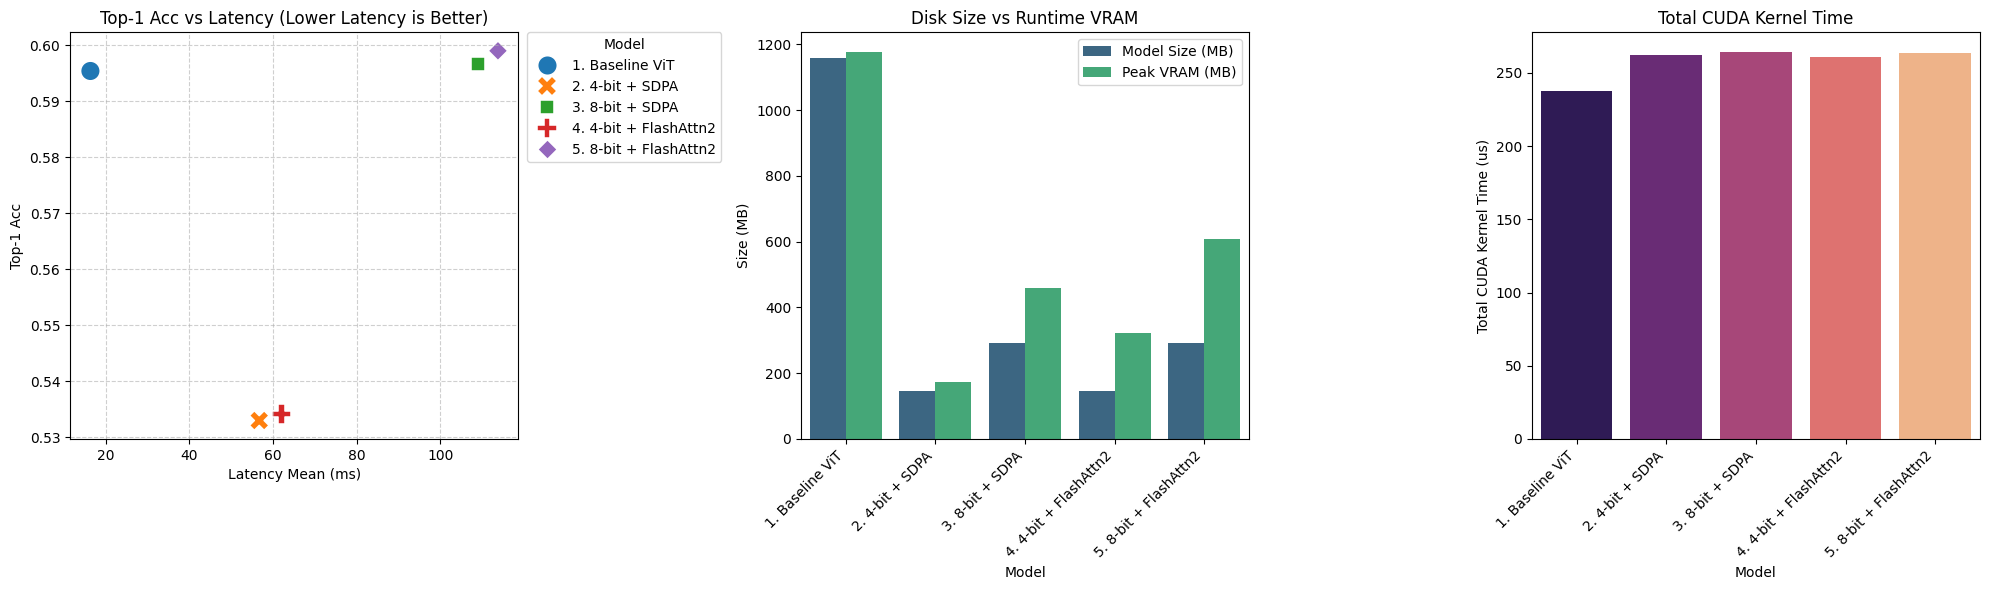

In [13]:
# Create DataFrame
if not all_metrics:
    print("No metrics collected yet. Please re-run the benchmark loop.")
else:
    df = pd.DataFrame(all_metrics)

    print("\n=== FINAL BENCHMARK RESULTS ===")
    display(df)

    # -------------------------------------------------
    # Visualization
    # -------------------------------------------------
    plt.figure(figsize=(20, 6))
    # Plot 1: Accuracy vs Latency
    plt.subplot(1, 3, 1)
    sns.scatterplot(data=df, x="Latency Mean (ms)", y="Top-1 Acc", hue="Model", s=200, style="Model", legend=True)
    plt.title("Top-1 Acc vs Latency (Lower Latency is Better)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    # Plot 2: Model Size vs VRAM
    plt.subplot(1, 3, 2)
    size_df = df[["Model", "Model Size (MB)", "Peak VRAM (MB)"]].melt("Model", var_name="Metric", value_name="Size (MB)")
    sns.barplot(data=size_df, x="Model", y="Size (MB)", hue="Metric", palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.title("Disk Size vs Runtime VRAM")
    plt.legend()

    # Plot 3: CUDA Time Breakdown
    plt.subplot(1, 3, 3)
    sns.barplot(data=df, x="Model", y="Total CUDA Kernel Time (us)", palette="magma")
    plt.xticks(rotation=45, ha='right')
    plt.title("Total CUDA Kernel Time")

    plt.tight_layout()
    plt.show()